# Embedding Ratings - Standard Approach

In [1]:
# TensorFlow Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

# Other
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, lil_matrix, vstack, load_npz
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')
tf.config.run_functions_eagerly(True)
#tf.data.experimental.enable_debug_mode()

## Classes and Methods

In [2]:
class EmbeddingRatings:
    def __init__(self, hidden_dim: int, k: int, input_dim: int):
        self.input_dim = input_dim
        input_vec = keras.Input(shape=(self.input_dim,))
        encoded = layers.Dense(hidden_dim, activation='relu')(input_vec)
        decoded = layers.Dense(input_dim, activation='relu')(encoded)
        
        self.autoencoder = keras.Model(input_vec, decoded)
        self.encoder = keras.Model(input_vec, encoded)
        self.autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        
        self.knn = NearestNeighbors(metric='cosine', n_neighbors=k)
    
    def fit(self, training_ratings: csr_matrix, epochs: int, batch_size: int):
        self.training_ratings = training_ratings

        generator = SparseDataGenerator(self.training_ratings, batch_size=batch_size)
        print('Fitting autoencoder...')
        self.autoencoder.fit(generator,
                             epochs=epochs,
                             shuffle=True)
        
        print('Creating embeddings...')
        self.embeddings = self.encoder.predict(self.training_ratings)
        self.knn.fit(self.embeddings)
        
    def predict(self, user_ratings):
        print('Embedding test users...')
        pred_embeddings = self.encoder.predict(user_ratings)
        
        print('Performing nearest-neighbor search in embedding space...')
        user_neighbors = self.knn.kneighbors(pred_embeddings, return_distance=False)
        
        print('Aggregating neighbor ratings...')
        pred = lil_matrix(user_ratings.shape)
        for idx, neighbor_indices in tqdm(enumerate(user_neighbors), total=user_neighbors.shape[0]):
            neighbors = self.training_ratings[neighbor_indices]
            divisor = neighbors.getnnz(axis=0)
            divisor[divisor == 0] = 1
            pred[idx] = neighbors.sum(axis=0) / divisor
 
        return pred.tocsr()

In [3]:
class SparseDataGenerator(keras.utils.Sequence):
    def __init__(self, x, batch_size):
        self.x = x
        self.batch_size = batch_size
        self.indices = np.arange(x.shape[0])

    def __len__(self):
        return int(np.ceil(self.x.shape[0] / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch = self.x[batch_indices].toarray()
        return batch, batch

In [4]:
def seen_unseen_split(ratings, fraction_seen=0.8):
    seen = lil_matrix(ratings.shape)
    unseen = lil_matrix(ratings.shape)

    for user_id in tqdm(range(ratings.shape[0])):
        rated_items_indices = ratings[user_id].nonzero()[1]
        np.random.shuffle(rated_items_indices)
        num_seen_items = int(fraction_seen * len(rated_items_indices))

        seen[user_id, rated_items_indices[:num_seen_items]] = ratings[user_id, rated_items_indices[:num_seen_items]]
        unseen[user_id, rated_items_indices[num_seen_items:]] = ratings[user_id, rated_items_indices[num_seen_items:]]

    return seen.tocsr(), unseen.tocsr()

## Data Preparation

In [5]:
sessions_train = load_npz("data/sessions_train.npz")
sessions_test = load_npz("data/sessions_test.npz")

In [6]:
seen, unseen = seen_unseen_split(sessions_test)

100%|██████████████████████████████████████████████████████████████████████████| 73939/73939 [00:31<00:00, 2316.36it/s]


## Usage

In [7]:
K.clear_session()

In [8]:
er = EmbeddingRatings(hidden_dim=128, k=250, input_dim=sessions_train.shape[1])
er.autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128910)]          0         
                                                                 
 dense (Dense)               (None, 128)               16500608  
                                                                 
 dense_1 (Dense)             (None, 128910)            16629390  
                                                                 
Total params: 33,129,998
Trainable params: 33,129,998
Non-trainable params: 0
_________________________________________________________________


In [9]:
er.fit(sessions_train, epochs=1, batch_size=256)

Fitting autoencoder...
1156/1156 [==============================] - 130s 112ms/step - loss: 2.6833e-04
Creating embeddings...
9243/9243 [==============================] - 41s 4ms/step


In [10]:
er.embeddings.shape

(295752, 128)

In [11]:
pred = er.predict(seen)

Embedding test users...
2311/2311 [==============================] - 9s 4ms/step
Performing nearest-neighbor search in embedding space...
Aggregating neighbor ratings...


73939it [04:06, 299.88it/s]


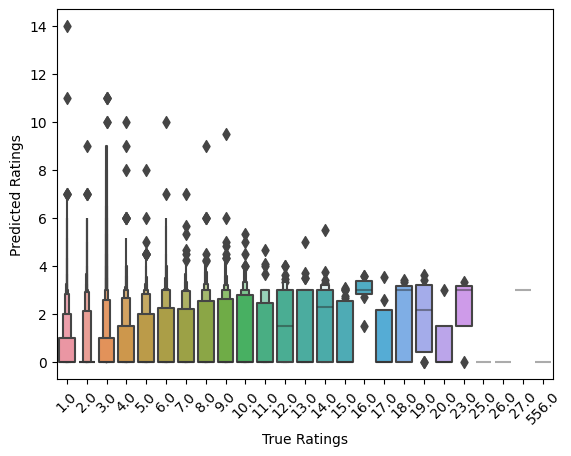

In [12]:
output = np.asarray(pred[unseen.nonzero()]).flatten() # Predictions lined up with unseen
#plt.scatter(unseen.data, output)
sns.boxenplot(x=unseen.data, y=output)
plt.xlabel('True Ratings')
plt.xticks(rotation=45)
plt.ylabel('Predicted Ratings')
plt.show()

In [13]:
RMSE = root_mean_squared_error(unseen.data, output)
correlation_coefficient, _ = pearsonr(unseen.data, output)
print(f"RMSE: {RMSE}\nR2: {correlation_coefficient ** 2}")

RMSE: 3.2265639657759273
R2: 0.003380806873066982


In [14]:
frac_nonzero_ratings = pred.nnz / np.prod(pred.shape)
frac_ratings_predicted = len(output.nonzero()[0]) / len(output)
print(f"Percent Nonzero: {frac_nonzero_ratings * 100}\nRecall (% unseen ratings predicted): {frac_ratings_predicted * 100}")

Percent Nonzero: 1.7045676920051414
Recall (% unseen ratings predicted): 26.666597538340298
